# Modelos de Regressão para Previsão de Preço

In [1]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### dados do twitter

In [2]:
%%time

###### IBOV ######

lista_tweets_01 = []

for i, tweet in enumerate(sntwitter.TwitterSearchScraper('IBOV since:2021-01-01 until:2021-12-31').get_items()):
    lista_tweets_01.append([tweet.date])
    
df_tweets_01 = pd.DataFrame(lista_tweets_01, columns=['Data'])

###### IBOVESPA ######

lista_tweets_02 = []

for i, tweet in enumerate(sntwitter.TwitterSearchScraper('IBOVESPA since:2021-01-01 until:2021-12-31').get_items()):
    lista_tweets_02.append([tweet.date])
    
df_tweets_02 = pd.DataFrame(lista_tweets_02, columns=['Data'])

###### BOVA11 ######

lista_tweets_03 = []

for i, tweet in enumerate(sntwitter.TwitterSearchScraper('BOVA11 since:2021-01-01 until:2021-12-31').get_items()):
    lista_tweets_03.append([tweet.date])
    
df_tweets_03 = pd.DataFrame(lista_tweets_03, columns=['Data'])

Wall time: 1h 3min 21s


In [3]:
print('a quantidade de pesquisas pelo termo IBOV ao longo do ano de 2021 foi de', df_tweets_01.shape[0])
print('a quantidade de pesquisas pelo termo IBOVESPA ao longo do ano de 2021 foi de', df_tweets_02.shape[0])
print('a quantidade de pesquisas pelo termo BOVA11 ao longo do ano de 2021 foi de', df_tweets_03.shape[0])

a quantidade de pesquisas pelo termo IBOV ao longo do ano de 2021 foi de 35069
a quantidade de pesquisas pelo termo IBOVESPA ao longo do ano de 2021 foi de 67283
a quantidade de pesquisas pelo termo BOVA11 ao longo do ano de 2021 foi de 1909


In [4]:
# df_tweets_01_ren = df_tweets_01.rename(columns = {'Tweet':'IBOV'})
# df_tweets_02_ren = df_tweets_02.rename(columns = {'Tweet':'IBOVESPA'})
# df_tweets_03_ren = df_tweets_03.rename(columns = {'Tweet':'BOVA11'})

# del df_tweets_01_ren['IBOV']
# del df_tweets_02_ren['IBOVESPA']
# del df_tweets_03_ren['BOVA11']

df_tweets_01['Data'] = pd.to_datetime(df_tweets_01['Data']).dt.date
df_tweets_02['Data'] = pd.to_datetime(df_tweets_02['Data']).dt.date
df_tweets_03['Data'] = pd.to_datetime(df_tweets_03['Data']).dt.date

df_tweets_01 = pd.DataFrame(df_tweets_01.groupby('Data')['Data'].count())
df_tweets_02 = pd.DataFrame(df_tweets_02.groupby('Data')['Data'].count())
df_tweets_03 = pd.DataFrame(df_tweets_03.groupby('Data')['Data'].count())

df_tweets_01.index = pd.to_datetime(df_tweets_01.index)
df_tweets_02.index = pd.to_datetime(df_tweets_02.index)
df_tweets_03.index = pd.to_datetime(df_tweets_03.index)

df_tweets_01 = df_tweets_01.resample('7D').sum()
df_tweets_02 = df_tweets_02.resample('7D').sum()
df_tweets_03 = df_tweets_03.resample('7D').sum()

df_tweets_01.reset_index(drop = True, inplace = True)
df_tweets_02.reset_index(drop = True, inplace = True)
df_tweets_03.reset_index(drop = True, inplace = True)

df_tweets_01.rename(columns = {'Data':'IBOV_TWITTER'}, inplace = True)
df_tweets_02.rename(columns = {'Data':'IBOVESPA_TWITTER'}, inplace = True)
df_tweets_03.rename(columns = {'Data':'BOVA11_TWITTER'}, inplace = True)

In [5]:
# dataframe com as três pesquisas
df_tweets = pd.concat([df_tweets_01, df_tweets_02, df_tweets_03], axis = 1)
print(df_tweets.shape[0])
df_tweets.head()

52


,IBOV_TWITTER,IBOVESPA_TWITTER,BOVA11_TWITTER
0,627,1327,47
1,664,1414,56
2,610,1351,25
3,667,1200,32
4,542,1322,21


### merge com dados do google e b3

In [6]:
df_b3_google = pd.read_csv('df_02.csv')
del df_b3_google['Unnamed: 0']

df_b3_google.rename(columns = {'Pesquisas sobre IBOV':'IBOV_GOOGLE', 'Pesquisas sobre IBOVESPA':'IBOVESPA_GOOGLE', 
                        'Pesquisas sobre BOVA11':'BOVA11_GOOGLE', 'preco_ultimo_negocio':'preco_fechamento'}, inplace = True)

print(df_b3_google.shape)
df_b3_google.head()

(52, 8)


,IBOV_GOOGLE,IBOVESPA_GOOGLE,BOVA11_GOOGLE,preco_abertura,preco_fechamento,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
0,0.636364,0.725490,1.000000,0.624014,0.667859,0.102255,0.444254,0.501934
1,0.545455,0.588235,1.000000,0.744163,0.728425,0.379796,0.296519,0.341386
2,0.545455,0.529412,0.666667,0.627725,0.610869,0.536285,0.225746,0.235650
3,0.545455,0.470588,0.666667,0.498106,0.497104,0.423400,0.457473,0.484596
4,0.454545,0.588235,0.666667,0.584970,0.593998,0.314002,0.338085,0.363696


In [7]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_tweets_pdr = df_tweets.copy()
df_tweets_pdr[["IBOV_TWITTER", "IBOVESPA_TWITTER", "BOVA11_TWITTER"]] = min_max_scaler.fit_transform(df_tweets[["IBOV_TWITTER", "IBOVESPA_TWITTER", "BOVA11_TWITTER"]])

df_modelagem = pd.merge(df_tweets_pdr, df_b3_google, left_index = True, right_index = True)
#df_modelagem.to_csv('df_modelagem.csv')
df_modelagem.head()

,IBOV_TWITTER,IBOVESPA_TWITTER,BOVA11_TWITTER,IBOV_GOOGLE,IBOVESPA_GOOGLE,BOVA11_GOOGLE,preco_abertura,preco_fechamento,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
0,0.299603,0.360849,0.600000,0.636364,0.725490,1.000000,0.624014,0.667859,0.102255,0.444254,0.501934
1,0.336310,0.412146,0.763636,0.545455,0.588235,1.000000,0.744163,0.728425,0.379796,0.296519,0.341386
2,0.282738,0.375000,0.200000,0.545455,0.529412,0.666667,0.627725,0.610869,0.536285,0.225746,0.235650
3,0.339286,0.285967,0.327273,0.545455,0.470588,0.666667,0.498106,0.497104,0.423400,0.457473,0.484596
4,0.215278,0.357901,0.127273,0.454545,0.588235,0.666667,0.584970,0.593998,0.314002,0.338085,0.363696


<AxesSubplot:xlabel='BOVA11_TWITTER', ylabel='Density'>

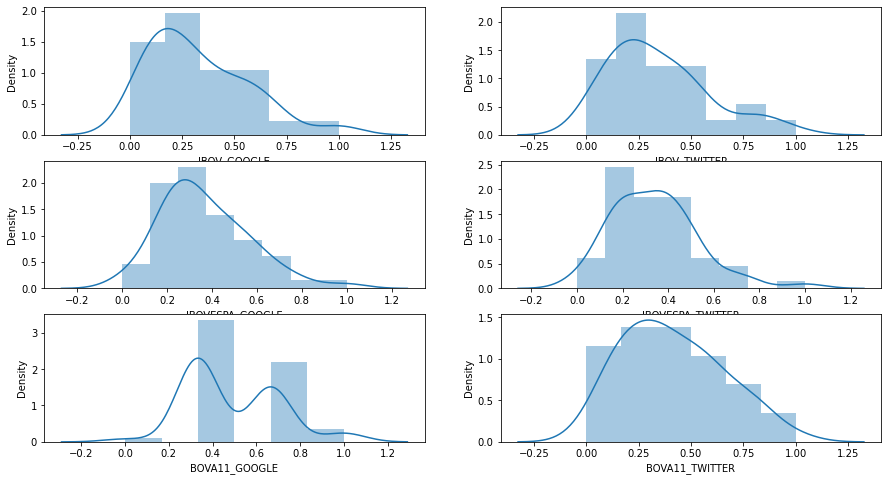

In [8]:
fig, axes = plt.subplots(3, 2, figsize = (15, 8))

sns.distplot(df_modelagem['IBOV_GOOGLE'], ax = axes[0, 0])
sns.distplot(df_modelagem['IBOV_TWITTER'], ax = axes[0, 1])
sns.distplot(df_modelagem['IBOVESPA_GOOGLE'], ax = axes[1, 0])
sns.distplot(df_modelagem['IBOVESPA_TWITTER'], ax = axes[1, 1])
sns.distplot(df_modelagem['BOVA11_GOOGLE'], ax = axes[2, 0])
sns.distplot(df_modelagem['BOVA11_TWITTER'], ax = axes[2, 1])

<AxesSubplot:xlabel='BOVA11_GOOGLE', ylabel='BOVA11_TWITTER'>

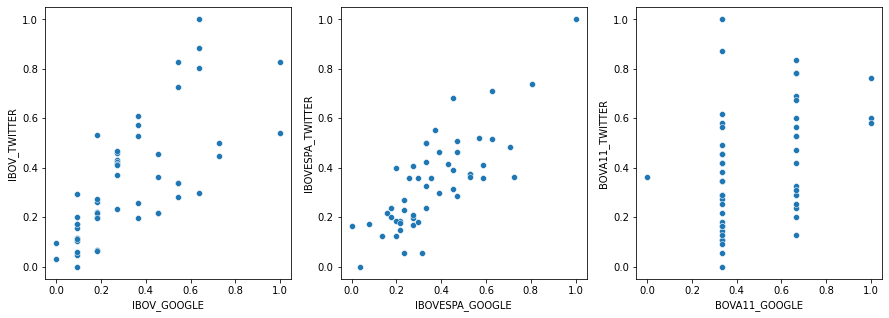

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

sns.scatterplot(x = df_modelagem['IBOV_GOOGLE'], y = df_modelagem['IBOV_TWITTER'], ax = axes[0])
sns.scatterplot(x = df_modelagem['IBOVESPA_GOOGLE'], y = df_modelagem['IBOVESPA_TWITTER'], ax = axes[1])
sns.scatterplot(x = df_modelagem['BOVA11_GOOGLE'], y = df_modelagem['BOVA11_TWITTER'], ax = axes[2])

In [10]:
df_modelagem[['IBOV_GOOGLE', 'IBOVESPA_GOOGLE', 'BOVA11_GOOGLE', 'IBOV_TWITTER', 'IBOVESPA_TWITTER', 'BOVA11_TWITTER', 
              'vol_total_negociado', 'qtd_papeis_negociados', 'qtd_negocios', 'preco_fechamento']].corr().iloc[:,:6]

,IBOV_GOOGLE,IBOVESPA_GOOGLE,BOVA11_GOOGLE,IBOV_TWITTER,IBOVESPA_TWITTER,BOVA11_TWITTER
IBOV_GOOGLE,1.000000,0.879315,0.505684,0.713926,0.797023,0.484238
IBOVESPA_GOOGLE,0.879315,1.000000,0.619077,0.503886,0.786404,0.422889
BOVA11_GOOGLE,0.505684,0.619077,1.000000,0.202778,0.453308,0.385355
IBOV_TWITTER,0.713926,0.503886,0.202778,1.000000,0.757833,0.548193
IBOVESPA_TWITTER,0.797023,0.786404,0.453308,0.757833,1.000000,0.555804
BOVA11_TWITTER,0.484238,0.422889,0.385355,0.548193,0.555804,1.000000
vol_total_negociado,0.835114,0.649820,0.370405,0.714596,0.707996,0.466486
qtd_papeis_negociados,0.827446,0.635341,0.295346,0.732018,0.712814,0.420627
qtd_negocios,-0.176062,-0.162280,-0.331230,0.000518,0.042791,-0.101011
preco_fechamento,-0.438024,-0.300464,0.138408,-0.430280,-0.415525,0.046509


### pré-modelagem

In [2]:
df_modelagem = pd.read_csv('df_modelagem.csv')
del df_modelagem['Unnamed: 0']

df_modelagem.head()

,IBOV_TWITTER,IBOVESPA_TWITTER,BOVA11_TWITTER,IBOV_GOOGLE,IBOVESPA_GOOGLE,BOVA11_GOOGLE,preco_abertura,preco_fechamento,qtd_negocios,qtd_papeis_negociados,vol_total_negociado
0,0.299603,0.360849,0.600000,0.636364,0.725490,1.000000,0.624014,0.667859,0.102255,0.444254,0.501934
1,0.336310,0.412146,0.763636,0.545455,0.588235,1.000000,0.744163,0.728425,0.379796,0.296519,0.341386
2,0.282738,0.375000,0.200000,0.545455,0.529412,0.666667,0.627725,0.610869,0.536285,0.225746,0.235650
3,0.339286,0.285967,0.327273,0.545455,0.470588,0.666667,0.498106,0.497104,0.423400,0.457473,0.484596
4,0.215278,0.357901,0.127273,0.454545,0.588235,0.666667,0.584970,0.593998,0.314002,0.338085,0.363696


In [3]:
# separação de features e resposta

X = df_modelagem.iloc[:,:6]
y = df_modelagem.preco_fechamento

In [4]:
# separar dados em treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# padronizando de forma que tire a inluência de outliers
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [5]:
# função de validação cruzada

from sklearn.model_selection import cross_val_score, KFold

n_folds = 5

def rmse_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X_train)
    return cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X_train)
    return cross_val_score(model, Xlv_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)

In [6]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# diferenciar métrica do XGBoost e retornar métricas de modelos 'simples'
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective = 'reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.06169 +/- 0.020322
Ridge: 0.05501 +/- 0.012742
Lasso: 0.08207 +/- 0.031863
ElasticNet: 0.08207 +/- 0.031863
RandomForestRegressor: 0.07053 +/- 0.021338
XGBRegressor: 0.08127 +/- 0.033725


### linear

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# fit e predict do modelo

LR = LinearRegression()
LR.fit(X_train, y_train) 
y_train_LR = LR.predict(X_train)
y_test_LR = LR.predict(X_test)

linear_results = pd.DataFrame({'Algoritmo':['Linear'],
            'MSE Treino': [mean_squared_error(y_train, y_train_LR)],
            'MSE Teste': [mean_squared_error(y_test, y_test_LR)],
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_LR)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_LR)],
            'R2 Treino': [r2_score(y_train, y_train_LR)],
            'R2 Teste': [r2_score(y_test, y_test_LR)]})

linear_results

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Linear,0.043215,0.04061,2.631495,1.298024e+14,0.459753,0.38236


<AxesSubplot:>

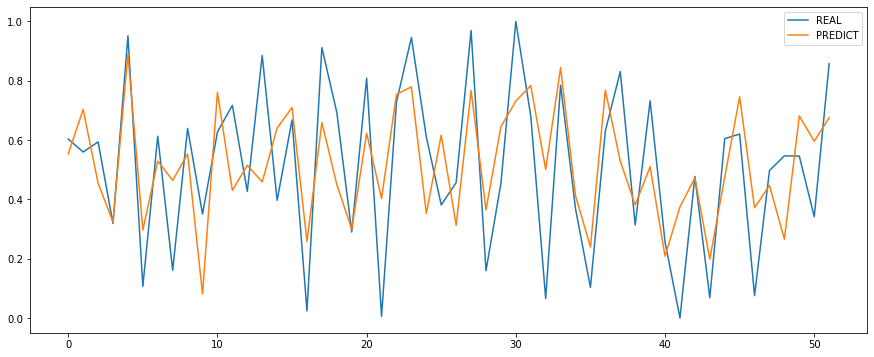

In [8]:
linear_train_values = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_LR})
linear_test_values = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_LR})

linear_values = pd.concat([linear_train_values, linear_test_values], axis = 0)
linear_values.reset_index(drop = True, inplace = True)
linear_values.plot(figsize = (15, 6))

### ridge regression

In [9]:
# definir melhor valor de regularização

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 25, 50, 75, 100] 
cv_ridge = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.DataFrame(cv_ridge, columns = ['RMSE'])
alphas = pd.DataFrame(alphas, columns = ['ALPHA'])
alpha_rmse = pd.concat([cv_ridge, alphas], axis = 1)
alpha_rmse.sort_values(by = 'RMSE')

,RMSE,ALPHA
4,0.054146,3.00
5,0.054946,5.00
3,0.055006,1.00
6,0.057620,10.00
2,0.057927,0.30
1,0.060069,0.10
0,0.060819,0.05
7,0.063365,25.00
8,0.068133,50.00
9,0.070744,75.00


In [10]:
# fit e predict do modelo

RR_CV_best = -rmse_cv(Ridge(alpha = 0.10))
RR = Ridge(alpha = 0.10) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)

ridge_results = pd.DataFrame({'Algoritmo':['Ridge'],
            'MSE Treino': [mean_squared_error(y_train, y_train_RR)],
            'MSE Teste': [mean_squared_error(y_test, y_test_RR)],
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_RR)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_RR)],
            'R2 Treino': [r2_score(y_train, y_train_RR)],
            'R2 Teste': [r2_score(y_test, y_test_RR)]})

ridge_results

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Ridge,0.043232,0.040007,2.649637,1.283870e+14,0.459534,0.391529


<AxesSubplot:>

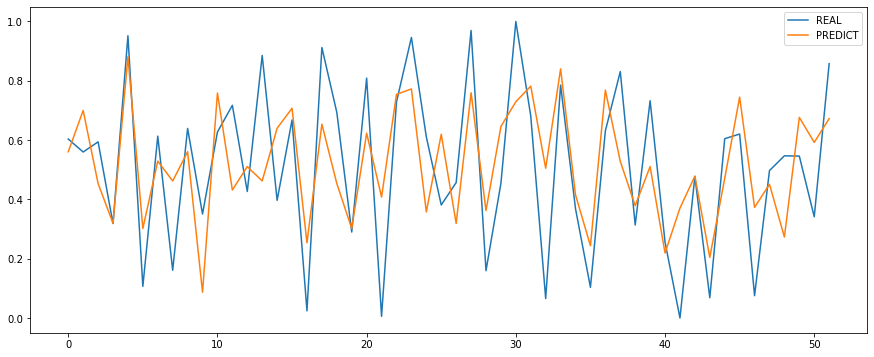

In [11]:
ridge_train_values = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_RR})
ridge_test_values = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_RR})

ridge_values = pd.concat([ridge_train_values, ridge_test_values], axis = 0)
ridge_values.reset_index(drop = True, inplace = True)
ridge_values.plot(figsize = (15, 6))

### lasso regression

In [12]:
# definir melhor valor de regularização

alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter = 2000)).mean() for alpha in alphas]

cv_lasso = pd.DataFrame(cv_lasso, columns = ['RMSE'])
alphas = pd.DataFrame(alphas, columns = ['ALPHA'])
alpha_rmse = pd.concat([cv_lasso, alphas], axis = 1)
alpha_rmse.sort_values(by = 'RMSE')

,RMSE,ALPHA
3,0.056930,0.0100
2,0.058635,0.0050
1,0.060054,0.0010
0,0.061517,0.0001
4,0.074668,0.0500
5,0.081614,0.1000
6,0.082075,0.3000
7,0.082075,1.0000


In [13]:
# fit e predict do modelo

lasso_CV_best = -rmse_cv(Lasso(alpha = 0.01))
lasso = Lasso(alpha = 0.01) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)

lasso_results = pd.DataFrame({'Algoritmo':['Lasso'],
            'MSE Treino': [mean_squared_error(y_train, y_train_lasso)],
            'MSE Teste': [mean_squared_error(y_test, y_test_lasso)],
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_lasso)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_lasso)],
            'R2 Treino': [r2_score(y_train, y_train_lasso)],
            'R2 Teste': [r2_score(y_test, y_test_lasso)]})

lasso_results

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Lasso,0.046464,0.038483,2.99742,1.218048e+14,0.419133,0.414706


Lasso selecionou 5 variáveis e eliminou 1


Text(0.5, 1.0, 'Coeficientes no Modelo')

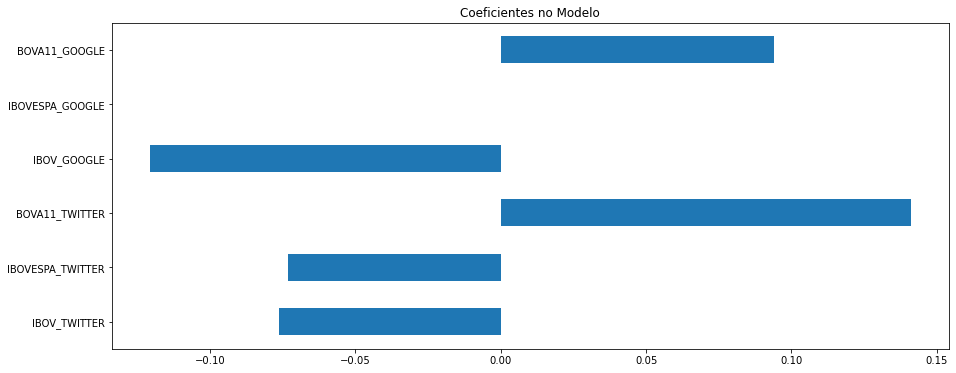

In [14]:
# features selecionadas e coeficientes

features = list(X.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso selecionou " + str(sum(coef != 0)) + " variáveis e eliminou " +  str(sum(coef == 0)))

coef.plot(kind = "barh", figsize = (15, 6))
plt.title("Coeficientes no Modelo")

<AxesSubplot:>

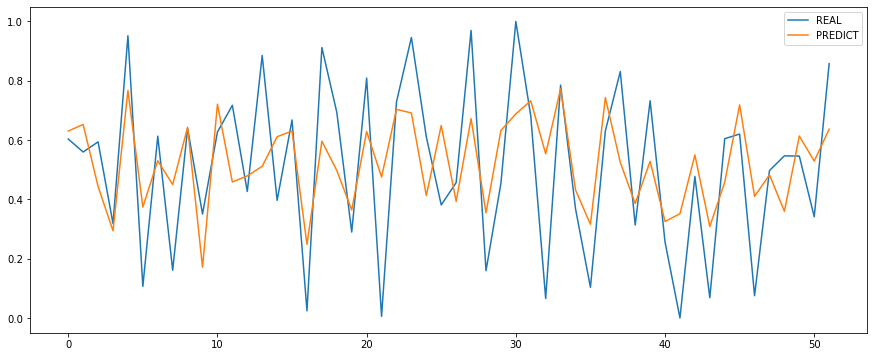

In [15]:
lasso_train_values = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_lasso})
lasso_test_values = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_lasso})

lasso_values = pd.concat([lasso_train_values, lasso_test_values], axis = 0)
lasso_values.reset_index(drop = True, inplace = True)
lasso_values.plot(figsize = (15, 6))

### random forest

In [16]:
# fit e predict do modelo

rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state = 42))
rfr_baseline = RandomForestRegressor(random_state = 42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfbase = rfr_baseline.predict(X_train)
y_test_rfbase = rfr_baseline.predict(X_test)

rfr_baseline_results = pd.DataFrame({'Algoritmo':['Random Forest Baseline'],
            'MSE Treino': [mean_squared_error(y_train, y_train_rfbase)],
            'MSE Teste': [mean_squared_error(y_test, y_test_rfbase)],
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_rfbase)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_rfbase)],
            'R2 Treino': [r2_score(y_train, y_train_rfbase)],
            'R2 Teste': [r2_score(y_test, y_test_rfbase)]})

rfr_baseline_results

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Random Forest Baseline,0.010549,0.058288,1.879703,9.619392e+13,0.868119,0.113482


<AxesSubplot:>

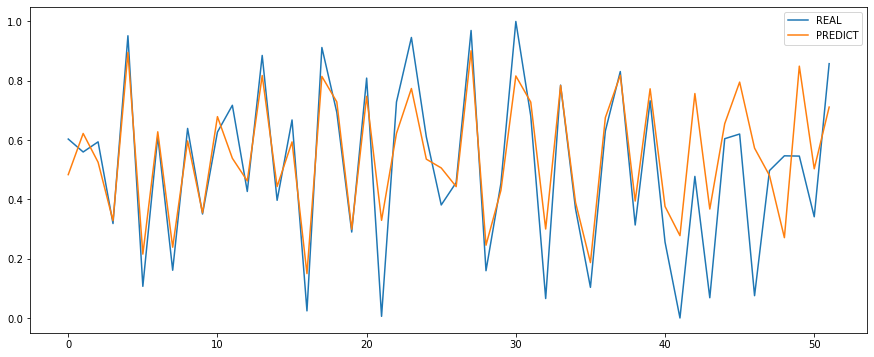

In [17]:
rfb_train_values = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_rfbase})
rfb_test_values = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_rfbase})

rfb_values = pd.concat([rfb_train_values, rfb_test_values], axis = 0)
rfb_values.reset_index(drop = True, inplace = True)
rfb_values.plot(figsize = (15, 6))

In [18]:
# selecionar hiperparâmetros a serem escolhidos

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

# tunning dos hiperparâmetros
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [19]:
# hiperparâmestros selecionados

best_random = RandomForestRegressor(bootstrap = False, criterion = 'mse', max_depth = 60, max_features = 'sqrt', 
                                    max_leaf_nodes = None, min_impurity_decrease = 0.0, min_impurity_split = None, 
                                    min_samples_leaf = 1, min_samples_split = 10, min_weight_fraction_leaf = 0.0, 
                                    n_estimators = 400, n_jobs = None, oob_score = False, random_state = 42, verbose = 0, 
                                    warm_start = False)

# fit e predict do modelo

rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'Algoritmo':['Random Forest Otimizado'],
            'MSE Treino': [mean_squared_error(y_train, y_train_rfr)],
            'MSE Teste': [mean_squared_error(y_test, y_test_rfr)],                 
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_rfr)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_rfr)],
            'R2 Treino': [r2_score(y_train, y_train_rfr)],
            'R2 Teste': [r2_score(y_test, y_test_rfr)]})

rfr_best_results

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Random Forest Otimizado,0.013999,0.046149,1.621562,8.904112e+13,0.824995,0.298107


<AxesSubplot:>

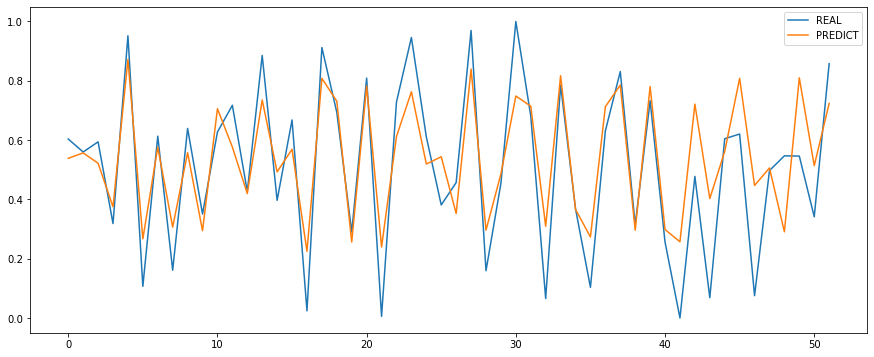

In [20]:
rfbest_train_values = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_rfr})
rfbest_test_values = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_rfr})

rfbest_values = pd.concat([rfbest_train_values, rfbest_test_values], axis = 0)
rfbest_values.reset_index(drop = True, inplace = True)
rfbest_values.plot(figsize = (15, 6))

In [21]:
# importância de cada feature

feat_imp = pd.DataFrame({'Features':X.columns, 'Importance':best_random.fit(X_train, y_train).feature_importances_})
feat_imp.sort_values(by = 'Importance', ascending = False, inplace = True)
feat_imp

,Features,Importance
4,IBOVESPA_GOOGLE,0.219054
3,IBOV_GOOGLE,0.207878
1,IBOVESPA_TWITTER,0.179494
0,IBOV_TWITTER,0.171161
2,BOVA11_TWITTER,0.144907
5,BOVA11_GOOGLE,0.077506


### xgboost regressor

In [22]:
# fit e predict do modelo

xgb_baseline = XGBRegressor(n_estimators = 1000, learning_rate = 0.05)
kf = KFold(n_folds, shuffle = True, random_state = 91).get_n_splits(X)
cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)

xgb_baseline_results = pd.DataFrame({'Algoritmo':['XGBoost Baseline'],
            'MSE Treino': [mean_squared_error(y_train, y_train_xgb_base)],
            'MSE Teste': [mean_squared_error(y_test, y_test_xgb_base)],                 
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_xgb_base)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_xgb_base)],
            'R2 Treino': [r2_score(y_train, y_train_xgb_base)],
            'R2 Teste': [r2_score(y_test, y_test_xgb_base)]})

xgb_baseline_results

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,XGBoost Baseline,7.193718e-07,0.057604,0.009199,7.700868e+13,0.999991,0.123887


<AxesSubplot:>

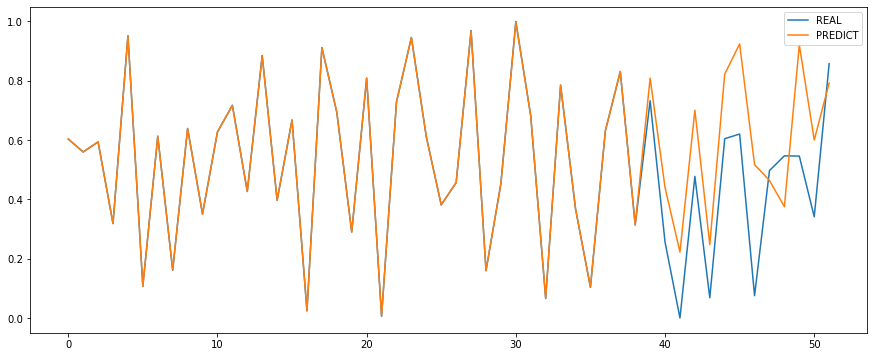

In [23]:
xgb_train_values = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_xgb_base})
xgb_test_values = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_xgb_base})

xgb_values = pd.concat([xgb_train_values, xgb_test_values], axis = 0)
xgb_values.reset_index(drop = True, inplace = True)
xgb_values.plot(figsize = (15, 6))

In [24]:
# otimização dos hiperparâmetros

d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}

for lr in [0.01, 0.05, 0.1, 0.5]:
    xgb_model = XGBRegressor(n_estimators = 1000, learning_rate = lr)
    cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
    xgb_model.fit(X_train, y_train)
    y_train_xgb = xgb_model.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

xgb_tuning_01 = pd.DataFrame(d)
xgb_tuning_01

,Learning Rate,Mean CV Error,CV Error Std,Training Error
0,0.01,0.081181,0.037522,1.997123e-06
1,0.05,0.080654,0.036359,7.193718e-07
2,0.10,0.078170,0.036959,6.874971e-07
3,0.50,0.074938,0.027724,7.845463e-07


In [25]:
# otimização dos hiperparâmetros 2

d = {'max_depth':[],
             'min_child_weight': [],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}

xgbreg = XGBRegressor(n_estimators = 2, learning_rate = 0.1)
params2 = {'max_depth': list(range(3, 10, 2)), 'min_child_weight': list(range(1, 6, 2))}

kf = KFold(n_folds, shuffle = True, random_state = 91).get_n_splits(X_train)

for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        xgb_model = XGBRegressor(n_estimators = 1000, learning_rate = 0.1, max_depth = md, min_child_weight = mcw )
        cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))
        
xgb_tuning_02 = pd.DataFrame(d)
xgb_tuning_02

,max_depth,min_child_weight,Mean CV Error,CV Error Std,Training Error
0,3,1,0.080155,0.024653,1.730144e-06
1,3,3,0.077922,0.029083,3.399699e-06
2,3,5,0.070398,0.013694,5.300047e-03
3,5,1,0.081167,0.036786,1.197784e-06
4,5,3,0.085999,0.020225,2.257898e-06
5,5,5,0.069868,0.012909,5.298931e-03
6,7,1,0.085340,0.039135,6.247451e-07
7,7,3,0.085341,0.020129,1.713111e-06
8,7,5,0.069868,0.012909,5.298931e-03
9,9,1,0.082894,0.036635,5.439298e-07


In [26]:
print('Valores ótimos:')
best = xgb_tuning_02.iloc[xgb_tuning_02.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

Valores ótimos:
max_depth: 5
min_child_weight: 5


In [27]:
# fit e predict do modelo

xbgreg_best = XGBRegressor(n_estimators = 1000, learning_rate = 0.1, max_depth = 3, min_child_weight = 1 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)

xgb_best_results = pd.DataFrame({'Algoritmo':['XGBoost Otimizado'],
            'MSE Treino': [mean_squared_error(y_train, y_train_xgbreg)],
            'MSE Teste': [mean_squared_error(y_test, y_test_xgbreg)],                 
            'MAPE Treino': [mean_absolute_percentage_error(y_train, y_train_xgbreg)],                  
            'MAPE Teste': [mean_absolute_percentage_error(y_test, y_test_xgbreg)],
            'R2 Treino': [r2_score(y_train, y_train_xgbreg)],
            'R2 Teste': [r2_score(y_test, y_test_xgbreg)]})

xgb_best_results

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,XGBoost Otimizado,0.000002,0.051805,0.009967,4.451458e+13,0.999978,0.212079


<AxesSubplot:>

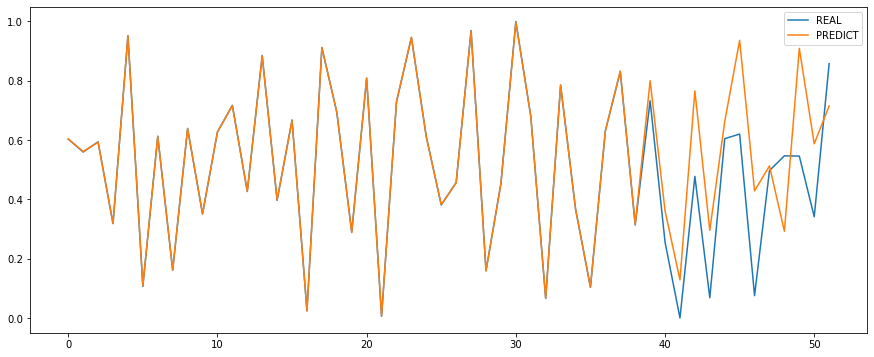

In [28]:
xbgreg_train_values = pd.DataFrame({'REAL':y_train, 'PREDICT':y_train_xgbreg})
xbgreg_test_values = pd.DataFrame({'REAL':y_test, 'PREDICT':y_test_xgbreg})

xbgreg_values = pd.concat([xbgreg_train_values, xbgreg_test_values], axis = 0)
xbgreg_values.reset_index(drop = True, inplace = True)
xbgreg_values.plot(figsize = (15, 6))

In [31]:
pd.concat([linear_results, ridge_results, lasso_results, rfr_baseline_results, rfr_best_results, xgb_baseline_results, xgb_best_results], axis = 0, ignore_index = True)

,Algoritmo,MSE Treino,MSE Teste,MAPE Treino,MAPE Teste,R2 Treino,R2 Teste
0,Linear,4.321469e-02,0.040610,2.631495,1.298024e+14,0.459753,0.382360
1,Ridge,4.323217e-02,0.040007,2.649637,1.283870e+14,0.459534,0.391529
2,Lasso,4.646395e-02,0.038483,2.997420,1.218048e+14,0.419133,0.414706
3,Random Forest Baseline,1.054923e-02,0.058288,1.879703,9.619392e+13,0.868119,0.113482
4,Random Forest Otimizado,1.399877e-02,0.046149,1.621562,8.904112e+13,0.824995,0.298107
5,XGBoost Baseline,7.193718e-07,0.057604,0.009199,7.700868e+13,0.999991,0.123887
6,XGBoost Otimizado,1.730144e-06,0.051805,0.009967,4.451458e+13,0.999978,0.212079


<AxesSubplot:title={'center':'XGBoost Otimizado'}>

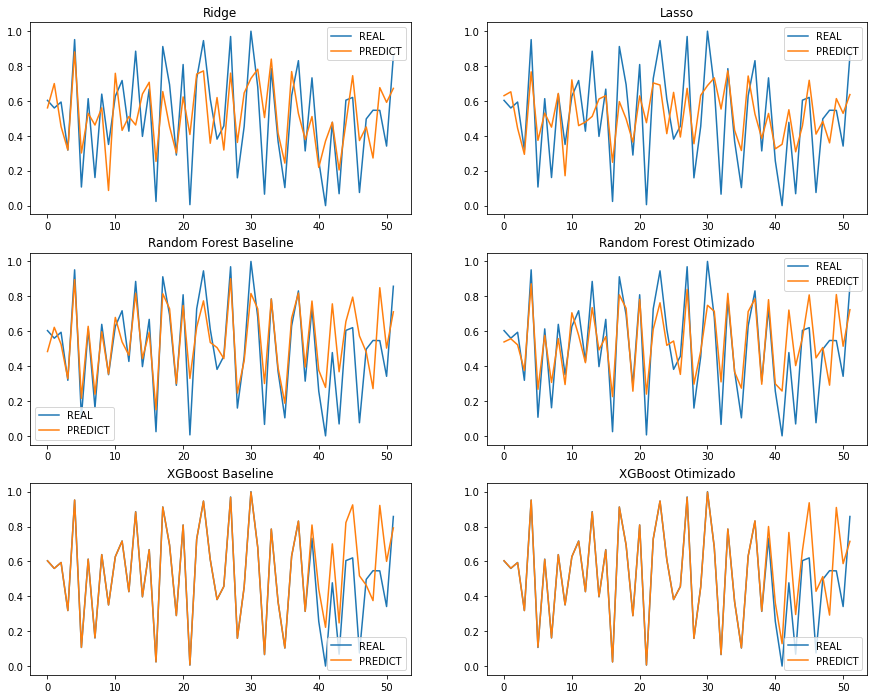

In [30]:
fig, axes = plt.subplots(3, 2, figsize = (15, 12))

ridge_values.plot(ax = axes[0, 0], title = 'Ridge')
lasso_values.plot(ax = axes[0, 1], title = 'Lasso')
rfb_values.plot(ax = axes[1, 0], title = 'Random Forest Baseline')
rfbest_values.plot(ax = axes[1, 1], title = 'Random Forest Otimizado')
xgb_values.plot(ax = axes[2, 0], title = 'XGBoost Baseline')
xbgreg_values.plot(ax = axes[2, 1], title = 'XGBoost Otimizado')